# CM 3070 Final Project

## CoCurricular Classification for University Advancement

Brian Van Steen 210182781

<a id='toc'></a>

### [1. Set Up](#setup)

### [2. Dataset](#dataset)

### [3. Visualizations](#visuals)

### [4. Categorical Encoding](#encoding)

<a id='setup'></a>
# 1. Set Up

This project is built using Anaconda JupyterLab, and a dedicated virtual environment was built for this notebook.

The following libraries were installed using 'pip' in the virtual environment terminal:

- NumPy
- Pandas
- Matplotlib
- Seaborn
- scikit-learn
- jupyterlab-git
- pyLDAvis
- TensorFlow
- openpyxl

Each of these libraries can now be imported for use.

In [1]:
# install all libraries

import numpy as np # Python library for working with arrays
import pandas as pd # Python library for data processing, working with CSV files
import matplotlib.pyplot as plt # used for basic visualzations and graph creations
%matplotlib inline
import seaborn as sns # used for advanced visualizations and graph creations

import nltk # import NLTK library for natural language processing
import re # import regular expression library for text pre-processing
import tokenization # import tokenization library

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split # use for Splitting the data between training data and test data
from sklearn.linear_model import LinearRegression # for creating the Linear Regression Model
from sklearn.preprocessing import MinMaxScaler # for normalization
from sklearn.preprocessing import PolynomialFeatures # for multivariate polynomial regression
from sklearn.tree import DecisionTreeClassifier # for cross-validation
from sklearn.linear_model import LogisticRegressionCV # logistic regression
from sklearn.naive_bayes import MultinomialNB # Naive Bayes
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeClassifier
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics import mean_squared_error # library for calculating metric
from sklearn.metrics import r2_score # library for calculating metric
from sklearn.metrics import accuracy_score

import tensorflow as tf
import keras
from keras import layers

import pyLDAvis
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings('ignore')

In [2]:
# as there are 23 attributes, show all columns when examining all data
pd.set_option('display.max_columns', None)

_[Table of Contents](#toc)_

<a id='dataset'></a>
# 2. Dataset

The dataset is provided by a Canadian university, consisting of all students who completed a degree or are in the processing of completing a degree, and who participate in co-curricular activities.

This dataset is created in an Excel .xlsx format, and was pre-processed in Excel as part of initial exploratory data analysis (EDA). While examining the data, the following pre-processing was completed:

- there were students included that did not have any data except the first three columns, implying they were not actually a student, and so these rows were deleted
- multiple columns were deleted for fields that were not relevant to co-curricular or donation activities
- the data was anonymized
- the columns heading were re-named and shortened, for ease-of-use

To start, the co-curricular dataset will be imported.

In [3]:
# import university co-curricular dataset as DataFrame from .xlsx file
# this required the install of openpyxl from the virtual environment terminal
prelimDataset = pd.read_excel('..\\Preliminary\\preliminaryReportData.xlsx')

In [4]:
# initial summary view of the DataFrame, the preliminary report dataset
prelimDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60996 entries, 0 to 60995
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ClassifierCode       60996 non-null  object        
 1   ActivityYear         60996 non-null  object        
 2   ActivityCategory     60996 non-null  object        
 3   PostCode             55836 non-null  object        
 4   Constituent          60996 non-null  object        
 5   GraduationYear       56932 non-null  datetime64[ns]
 6   Faculty              56932 non-null  object        
 7   Degree               56932 non-null  object        
 8   Exclusions           2587 non-null   object        
 9   LifetimeDollars      15377 non-null  float64       
 10  LifetimeGifts        15377 non-null  float64       
 11  RFMRC                15409 non-null  float64       
 12  RFMFR                15409 non-null  float64       
 13  RFMMO                15409 non-

### Preliminary Summary

After initial cleansing the data in Excel, the preliminary data set included 60,996 records that represent anonymized information for the university students.

The co-curricular data that will be analyzed in this study are in the second and third columns, AcitivityYear and ActivityCategory. These represent activities undertaken by students while studying at univeristy

The rest of the columns details information about the student, including a mailing postal code, faculty and degree completed, graduation year, and donation information.

An overview of the data is shown below.

In [5]:
prelimDataset.head()

,ClassifierCode,ActivityYear,ActivityCategory,PostCode,Constituent,GraduationYear,Faculty,Degree,Exclusions,LifetimeDollars,LifetimeGifts,RFMRC,RFMFR,RFMMO,RFMTO,FirstGiftYear,FirstAmount,FirstArea,FirstSolicitation,LargestGiftYear,LargestAmount,LargestArea,LargestSolicitation
0,6K223BZ,2010-2011,"Education, Training and Outreach",K2,Alumnus,2008-10-24,Faculty:Arts & Social Sciences,Bachelor of Arts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
1,KBZ43K4,2015-2016,Student Government and Student and Residence Life,K2,Alumnus Parent employee,2017-02-17,Faculty:Public Affairs,Bachelor of Arts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
2,KBZ43K4,2014-2015,"Panels, Events, Committees and Conferences",K2,Alumnus Parent employee,2017-02-17,Faculty:Public Affairs,Bachelor of Arts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
3,KBZ43K4,2014-2015,"Panels, Events, Committees and Conferences",K2,Alumnus Parent employee,2017-02-17,Faculty:Public Affairs,Bachelor of Arts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
4,KKK0BZ0,2012-2013,"Academics, Awards and Research",K1,Alumnus,2016-05-27,Faculty:Public Affairs,Bachelor of Arts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN


### Update

Based on additional analysis of the data, as well as the opportunity to append additional data, the dataset was updated and further **dataset type** pre-processing was applied.

In addition to the co-curricular activities, post graduation alumni activities were added to the dataset. Additionally, it was identified that an additional co-curricular field would be used that have previously been dropped.

Additionally, as each co-curricular activity undertaking by the student is represented by a single row, a student can appear in multiple rows. While this was useful for tracking the co-curricular activities, singular data for the student is then repeated. For example, in the overview above, student 'KBZ43K4' (annonymized) has three rows of co-curricular activities over two years (2014 - 2015, ad 2015 - 2016). But that student only has one postal code, graduation year, faculty, etc.

Therefore, the 60,996 needed to be collapsed based on the 'ClassifierCode' while retaining all the co-curricular data as well as the 'singular' datapoints. Based on research and given the data is in an Excel format, the best solution identified was using an Excel Power Query, to transform the data with a 'Group By' | 1 |. Using a Power Query script, all the rows were grouped using the ClassifiedCode, all co-curricular data was concatenated into a single columns (ActivityYear, ActivityCategory, and ActivityDepartment), and then the singular data were returned as single values using a 'max' evaluation.

In preparation for the Power Query script, further data cleansing was applied in Excel, since the Power Query effort was completed in Excel. This clenasing included rationalizing duplicated co-curricular values (i.e., equivalent values that used 'and' as well as '&') as well as anonymizing the ActivityDepartment co-curricular field.

Finally, all the concatenated data need to be split, to enable categorical encoding during the machine learning processes. While this can be easily done in pandas using string.split methods, this was completed in Excel since it was just a continuation of the Power Query process. In Excel, the 'Text to Column' function allows delimited data in one column to be split into multiple columns based on the delimiter.

As part of the research to identify a method to collapse the rows, it was attempted to identify a pandas method that would achieve the same result. While the functionality exists to collapsed rows based on an ID using pandas | 2 |, I could not identify a pandas method that would both concatenate multiple data points for some columns while also returning on a single value for singular data. A more recent dataframe library, Polars, may have additional functionality, but searches related to Polars did not return anything.

| 1 | https://community.fabric.microsoft.com/t5/Power-Query/Combining-Rows-based-on-the-ID-of-that-table/td-p/2374464

| 2 | https://stackoverflow.com/questions/70505040/pandas-collapse-rows-with-same-column-id-and-concatenate-multiple-columns-into

In [6]:
# import updated university co-curricular dataset as DataFrame from .xlsx file
studentDataset = pd.read_excel('..\\..\\Data\\coCurricular.xlsx')

In [7]:
studentDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17714 entries, 0 to 17713
Data columns (total 66 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Sort                 17714 non-null  object        
 1   RFMRC                4377 non-null   float64       
 2   RFMFR                4377 non-null   float64       
 3   RFMMO                4377 non-null   float64       
 4   RFMTO                4377 non-null   float64       
 5   Exclusions           707 non-null    object        
 6   Postal               17714 non-null  object        
 7   StartYear            17714 non-null  int64         
 8   Cat1                 17714 non-null  object        
 9   Cat2                 10712 non-null  object        
 10  Cat3                 7318 non-null   object        
 11  Cat4                 5314 non-null   object        
 12  Cat5                 4012 non-null   object        
 13  Cat6                 3115 non-n

### Final Summary

Based on the updated dataset that was collapse, we now have the following records, as detailed above:

- 17,714 individual student records (versus 60,996 total records), implying each student on average participated in more than 3 co-curricular activities
- specific data for these 17,714 students, including PostalCode, StartYear and Constituent
- of these, there are 4,377 target labels for students that have made donations (RFMRC, RFMFR, RFMMO, RFMTO)
- the donation data for the 4,363 students that made donations (the discrepency is individuals who have donated through a company)
- the split co-curricular data is now captured in individual fields, Cat 1 - 16, and Dept 1 - 16
- the appended alumni activity data is also captured in individual fields, Activity 1 - 12

As shown above, all 17,714 students have a least one co-curricular activity shown in Cat1 and Dept1. But the number of students with greater number of activities drops off for the higher valued Cat and Dept fields.

Additionally, while a large number of alumni participated in post-graduation activities (10,445 for Activity1), the number decreases significantly for higher values Activity fields.

A summary of the dataset is shown below.

In [8]:
studentDataset.head()

,Sort,RFMRC,RFMFR,RFMMO,RFMTO,Exclusions,Postal,StartYear,Cat1,Cat2,Cat3,Cat4,Cat5,Cat6,Cat7,Cat8,Cat9,Cat10,Cat11,Cat12,Cat13,Cat14,Cat15,Cat16,Dept1,Dept2,Dept3,Dept4,Dept5,Dept6,Dept7,Dept8,Dept9,Dept10,Dept11,Dept12,Dept13,Dept14,Dept15,Dept16,Constituent,Graduation,Faculty,Degree,LifetimeDollars,LifetimeGifts,FirstYear,FirstAmount,FirstArea,FirstSolicitation,LargestYear,LargestAmount,LargestArea,LargestSolicitation,Activity1,Activity2,Activity3,Activity4,Activity5,Activity6,Activity7,Activity8,Activity9,Activity10,Activity11,Activity12
0,8g31t83,20.0,15.0,6.0,41.0,NaN,T2,2012,Academic Success,Academic Success,Athletics and Recreation,Athletics and Recreation,Athletics and Recreation,Athletics and Recreation,Athletics and Recreation,Education and Outreach,Student Life Programs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Department1,Department2,Department3,Department4,Department5,Department6,Department7,Department8,Department9,Department10,Department11,Department12,Department13,Department14,Department15,Department16,Alumnus,2017-06-02,Public Affairs,Bachelor of Arts,3525.00,63.0,43068.0,300.0,Athletics,Email,44533.0,1500.0,Athletics,Email,Alumni Athletics Volunteer,Alumni Association Executive,Alumni Association Executive,Alumni Volunteer,Alumni Volunteer,Student Residence,Student Sports,NaN,NaN,NaN,NaN,NaN
1,8gX1t83,NaN,NaN,NaN,NaN,NaN,K1,2010,Academic Success,Academic Success,Academic Success,Leadership and Development,Leadership and Development,Leadership and Development,Clubs/Societies/Associations,Clubs/Societies/Associations,Clubs/Societies/Associations,Clubs/Societies/Associations,Education and Outreach,Special Events,Student Life Programs,NaN,NaN,NaN,Learning Support Services,University Administrative Department,Athletics,Athletics,Athletics,Athletics,University Administrative Department,Employability,Student Government,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alumnus Employee,2014-05-30,Public Affairs,Bachelor of Arts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alumni Association Executive,Alumni Association Executive,Alumni Volunteer,Student Residence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ygz1t8,20.0,20.0,2.0,42.0,NaN,K1,2012,Academic Success,Academic Success,Clubs/Societies/Associations,Clubs/Societies/Associations,Clubs/Societies/Associations,Clubs/Societies/Associations,Clubs/Societies/Associations,Clubs/Societies/Associations,Clubs/Societies/Associations,Competition Team,Competition Team,Special Events,Special Events,Special Events,Special Events,Student Life Programs,Learning Support Services,Learning Support Services,University Administrative Department,Academic Improvement,Academic Improvement,Academic Improvement,University School of Journalism and Communica...,University School of Journalism and Communica...,University School of Journalism and Communica...,Student Government,Accessibility,University Administrative Department,University Orientation,NaN,NaN,NaN,Alumnus,2017-06-02,Engineering & Design,Bachelor of Engineering,654.75,234.0,41373.0,50.0,Faculty:Engineering & Design,Levy,43650.0,75.0,University Wide,Email,Student Volunteer,Alumni Association Executive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6gZ1t83,NaN,NaN,NaN,NaN,NaN,J9,2010,Leadership and Development,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Faculty of Engineering,Faculty of Engineering,Faculty of Engineering,Faculty of Engineering,Faculty of Engineering,Faculty of Engineering,Faculty of Engineering,University Student Engineering Society,University Student Engineering Society,Faculty of Engineering,University Student Engineering Society,Faculty of Engineering,University Administrative Department,University Administrative Department,University Administrative Department,University Orientation,Alumnus,2009-05-29,School of Business,Bachelor of Commerce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alumni Award Winner,Alumni Award Winner Winner,Alumni Volunteer,Alumni Profiled in Publication,Student Residence,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3g21t87,NaN,NaN,NaN,NaN,NaN,K2,2

Based on the summary, a few fields require additional **data-oriented** preprocessing, as follows.

The only fields that should have numerical data are then shown with their statistical values.

In [9]:
# reset date-type columns using just the 'year' data from the existing datatime dtype columns, and set all as objects
studentDataset['StartYear'] = studentDataset['StartYear'].astype(object)
studentDataset['Graduation'] = studentDataset['Graduation'].dt.strftime('%Y')
studentDataset['FirstYear'] = studentDataset['FirstYear'].astype(object)
studentDataset['LargestYear'] = studentDataset['LargestYear'].astype(object)

In [10]:
studentDataset.describe()

,RFMRC,RFMFR,RFMMO,RFMTO,LifetimeDollars,LifetimeGifts,FirstAmount,LargestAmount
count,4377.000000,4377.000000,4377.000000,4377.000000,4363.000000,4363.000000,4363.000000,4363.000000
mean,10.793466,11.889879,2.103267,24.786155,250.982576,16.067385,58.241348,98.522576
std,8.282011,3.128090,1.078852,8.863708,568.046237,31.617941,130.097102,277.798993
min,1.000000,1.000000,0.000000,4.000000,0.010000,1.000000,0.000000,0.000000
25%,1.000000,10.000000,2.000000,18.000000,92.000000,4.000000,25.000000,50.000000
50%,10.000000,10.000000,2.000000,27.000000,204.250000,7.000000,50.000000,54.000000
75%,20.000000,15.000000,2.000000,32.000000,250.000000,16.000000,50.000000,63.000000
max,20.000000,20.000000,50.000000,70.000000,18724.000000,784.000000,2250.000000,6203.000000


As shown in the statistical table above, there are now 8 fields of numerical data, with 4,377 records of the target lables relating to RFM and 4,363 records for donation amounts.

Some further data cleansing has been identified, as there are 173 records of total donations for less than $10. These are records where a student's payment account has a credit balance, and the student agrees to 'donate' the remaining balance to the university.

As this is more of a 'reactive' than 'proactive' donation, since the values are small in comparison to the 75% level, and since it is a small amount of records, these values will not be included in the analyses.

_[Table of Contents](#toc)_

<a id='visuals'></a>
# 3. Visualizations

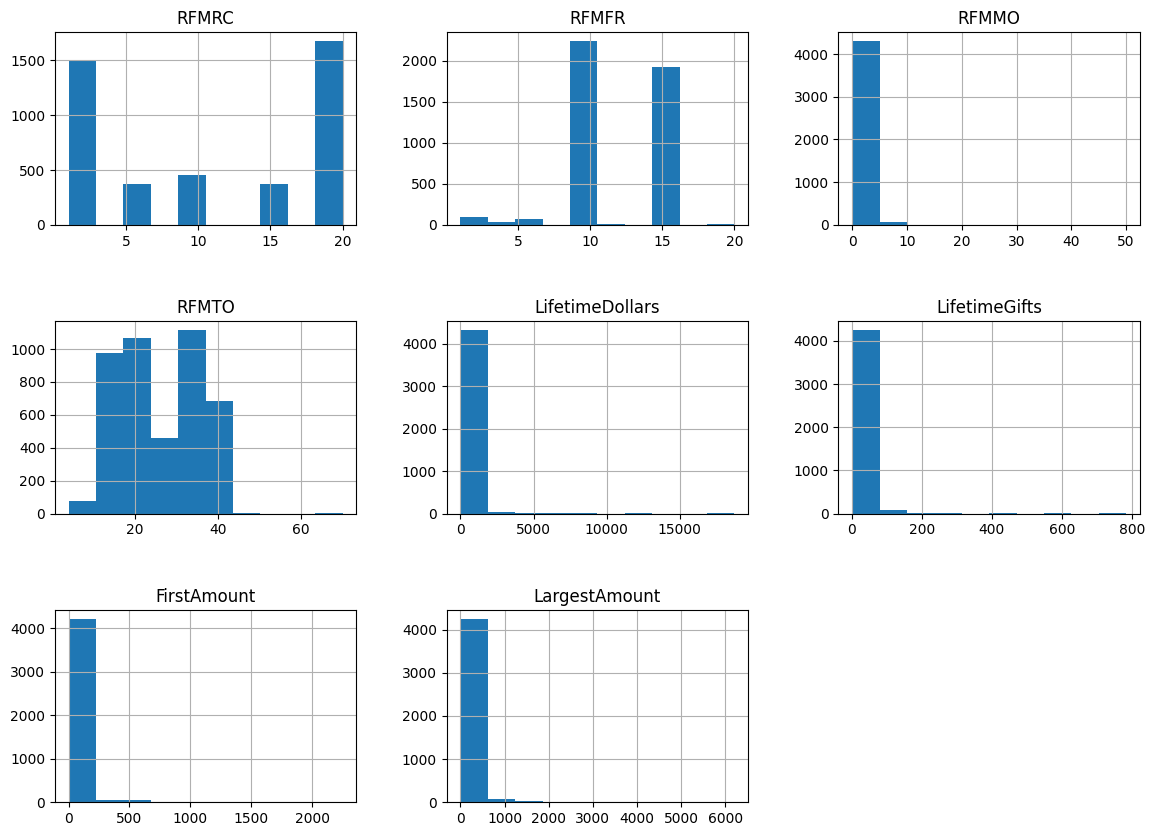

In [11]:
studentDataset.hist(figsize = (14, 10))
plt.subplots_adjust(hspace=0.5) 
plt.show()

The above histograms visually detail what the statistical table documented.

There is a lot of positive skew to the data for donation amounts, with a very small amount of high value outliers.

For the RFM score, aside from the Recency score that is shows many donations completed in the last year, again the data is positively skewed.

For all of these numerical values (except RFM Monetary), large standard deviations are calculated, as documented in the statistical table above.

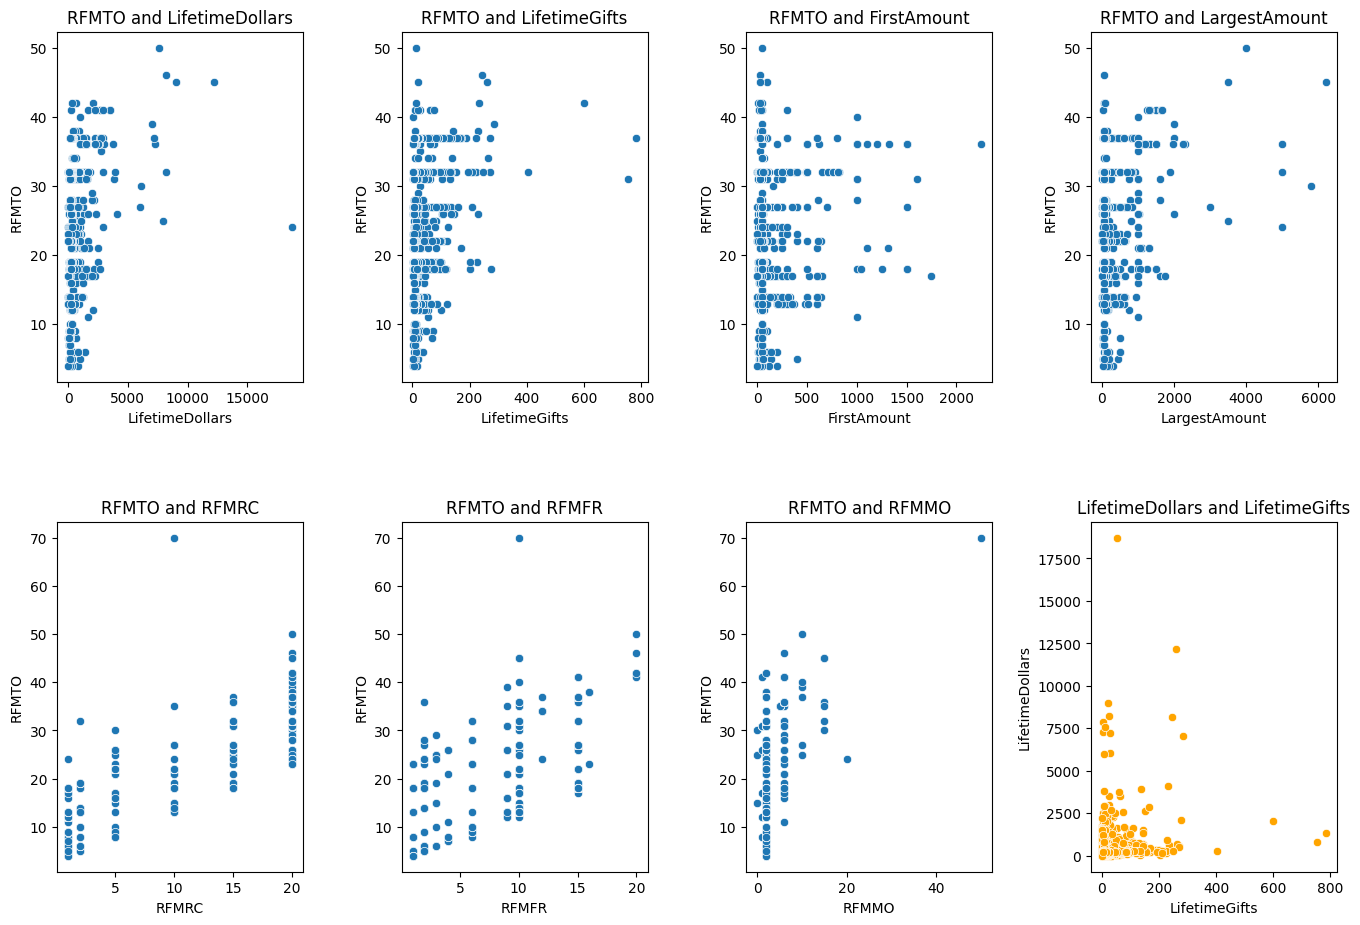

In [12]:
# scatter plots for 8 quantitative values

fig, axs = plt.subplots(2, 4, figsize=(16, 12)) # 8 scatterplots
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.8, wspace=0.4, hspace=0.4)

axs[0, 0].set_title('RFMTO and LifetimeDollars')
axs[0, 0].set_ylabel("RFMTO")
axs[0, 0].set_xlabel("LifetimeDollars")
sns.scatterplot(data = studentDataset, ax = axs[0, 0], x = "LifetimeDollars", y = "RFMTO")

axs[0, 1].set_title('RFMTO and LifetimeGifts')
axs[0, 1].set_ylabel("RFMTO")
axs[0, 1].set_xlabel("LifetimeGifts")
sns.scatterplot(data = studentDataset, ax = axs[0, 1], x = "LifetimeGifts", y = "RFMTO")

axs[0, 2].set_title("RFMTO and FirstAmount")
axs[0, 2].set_ylabel("RFMTO")
axs[0, 2].set_xlabel("FirstAmount")
sns.scatterplot(data = studentDataset, ax = axs[0, 2], x = "FirstAmount", y = "RFMTO")

axs[0, 3].set_title("RFMTO and LargestAmount")
axs[0, 3].set_ylabel("RFMTO")
axs[0, 3].set_xlabel("LargestAmount")
sns.scatterplot(data = studentDataset, ax = axs[0, 3], x = "LargestAmount", y = "RFMTO")

axs[1, 0].set_title("RFMTO and RFMRC")
axs[1, 0].set_ylabel("RFMTO")
axs[1, 0].set_xlabel("RFMRC")
sns.scatterplot(data = studentDataset, ax = axs[1, 0], x = "RFMRC", y = "RFMTO")

axs[1, 1].set_title("RFMTO and RFMFR")
axs[1, 1].set_ylabel("RFMTO")
axs[1, 1].set_xlabel("RFMFR")
sns.scatterplot(data = studentDataset, ax = axs[1, 1], x = "RFMFR", y = "RFMTO")

axs[1, 2].set_title("RFMTO and RFMMO")
axs[1, 2].set_ylabel("RFMTO")
axs[1, 2].set_xlabel("RFMMO")
sns.scatterplot(data = studentDataset, ax = axs[1, 2], x = "RFMMO", y = "RFMTO")

axs[1, 3].set_title("LifetimeDollars and LifetimeGifts")
axs[1, 3].set_ylabel("LifetimeDollars")
axs[1, 3].set_xlabel("LifetimeGifts")
sns.scatterplot(data = studentDataset, ax = axs[1, 3], c = 'orange', x = "LifetimeGifts", y = "LifetimeDollars")

plt.show()

### Pearson Correlation Coefficient

While the focus of this study is on classification, are part of basic EDA the Pearson Correlation Coefficients will be calculated for these numerical values, to evaluate linear correlation.

In [13]:
# calculate Peason correlation coefficient for Price, Year, Mileage and Owners
pearsoncorr = studentDataset[["RFMTO", "RFMRC", "RFMFR", "RFMMO", "LifetimeDollars", "LifetimeGifts", "FirstAmount", "LargestAmount"]].corr(method='pearson')
pearsoncorr

,RFMTO,RFMRC,RFMFR,RFMMO,LifetimeDollars,LifetimeGifts,FirstAmount,LargestAmount
RFMTO,1.000000,0.931022,0.328415,0.116442,0.097419,0.134170,-0.030138,0.070048
RFMRC,0.931022,1.000000,-0.016826,0.021953,0.024223,0.074332,-0.027056,0.028923
RFMFR,0.328415,-0.016826,1.000000,-0.073418,0.002873,0.158299,-0.112712,-0.099909
RFMMO,0.116442,0.021953,-0.073418,1.000000,0.840611,0.096456,0.404216,0.899506
LifetimeDollars,0.097419,0.024223,0.002873,0.840611,1.000000,0.223442,0.303510,0.855185
LifetimeGifts,0.134170,0.074332,0.158299,0.096456,0.223442,1.000000,-0.022667,0.074497
FirstAmount,-0.030138,-0.027056,-0.112712,0.404216,0.303510,-0.022667,1.000000,0.501917
LargestAmount,0.070048,0.028923,-0.099909,0.899506,0.855185,0.074497,0.501917,1.000000


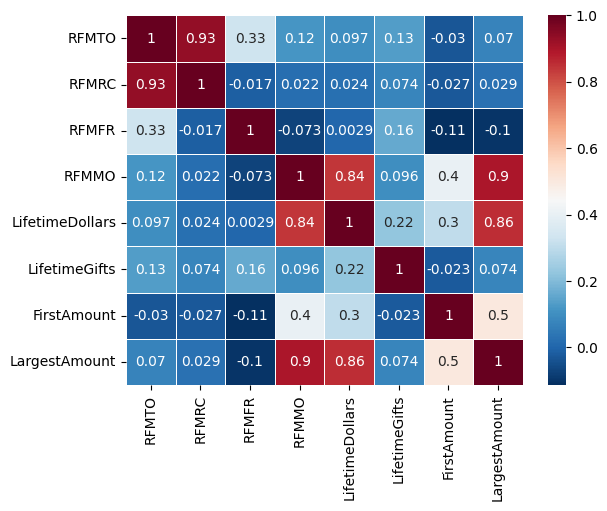

In [14]:
# visualize the correlation coefficient values from the table above
sns.heatmap(pearsoncorr, xticklabels=pearsoncorr.columns, yticklabels=pearsoncorr.columns, cmap='RdBu_r', annot=True, linewidth=0.5);

As shown in the red sections of the heat map, there is expected higher levels of correlation between RFM Monetary scores, lifetime dollars and large donation amounts.

_[Table of Contents](#toc)_

<a id='encoding'></a>
# 4. Categorical Encoding